In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_wine
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
X, y = load_wine(return_X_y=True)
print(f'Data has shape: {X.shape}')

Data has shape: (178, 13)


In [3]:
#helper function for PCA
def standardize(X):
    '''
    Standardizes data, subtracting mean and dividing by standard deviation
    '''
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    norm_parameters = np.vstack([mean, std])
    X_norm = (X - mean) / std
    
    return X_norm, norm_parameters

In [4]:
#covariance, correlation or SVD can be used in PCA. This class incorporates all of them
class Eigendecomposition:
        
    def covariance(self, X):
        """
        Calculates eigenvectors and eigenvalues of covariance matrix
        """
        
        m = X.shape[0]
        cov = np.dot(X.T, X) / (m-1)
        e_val, e_vect = np.linalg.eig(cov)

        return e_val, e_vect
    
    def correlation(self, X):
        """
        Calculates eigenvectors and eigenvalues of correlation matrix
        """
        
        m = X.shape[0]
        n = X.shape[1]
        
        cov = np.dot(X.T, X) / (m-1)
        variance = np.array([cov[i, i] for i in np.arange(n)])[:, np.newaxis]
        corr = np.zeros((n, n))
        
        for i in range(n):
            for j in range(n):
                corr[i, j] = cov[i, j] / (np.sqrt(cov[i, i] * cov[j, j]))
        
        e_val, e_vect = np.linalg.eig(corr)
        
        return e_val, e_vect
    
    def svd(self, X):
        """
        Calculates eigenvectors and eigenvalues by means of svd
        """
        
        m = X.shape[0]
        
        u, s, v = np.linalg.svd(X.T)
        e_val = s**2 / (m - 1)
        e_vect = u
        
        return e_val, e_vect
        

In [5]:
class PCA:
    
    def __init__(self, X, n, eigendecomposition):
        self.X = X       #matrix of input features
        self.n = n       #number of principal components
        self.eigendecomposition = eigendecomposition
        self.X_norm = None
        self.norm_params = None
        self.reduced = None
        self.matrix_w = None
        
        
    def transform(self):
        """
        Reduces data feature dimension to n
        """
        
        self.X_norm, self.norm_params = standardize(self.X)
        
        e_vals, e_vect = self.eigendecomposition(self.X_norm)
        idx = np.argsort(e_vals)[::-1]
        
        matrix_w = e_vect[:, idx[:self.n]]
        transformed = np.dot(self.X_norm, matrix_w)
        
        self.reduced = transformed
        self.matrix_w = matrix_w

        return transformed, matrix_w

        
    def restore(self):
        """
        Restores "original" data   
        """
        return (self.reduced @ self.matrix_w.T) * self.norm_params[1] + self.norm_params[0]

In [7]:
#reduce dimensions of feature space to 2
pca = PCA(X, 2, Eigendecomposition().correlation)
X_reduced, _ = pca.transform()

Text(0, 0.5, 'PC2')

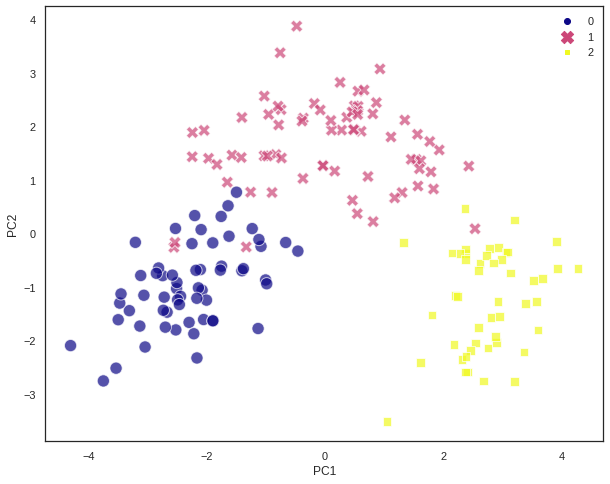

In [35]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(10, 8))
sns.scatterplot(X_reduced[:, 0], X_reduced[:, 1], hue=y, alpha=0.7, style=y, palette='plasma', 
                size=1, sizes=(150, 350))
plt.xlabel('PC1')
plt.ylabel('PC2')

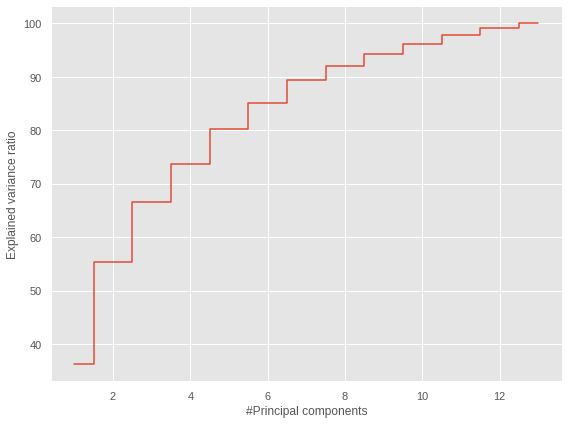

In [40]:
#plot 'explained variance' to figure out an appropriate number of principal components
X_norm, _ = standardize(X)
e_val, _ = Eigendecomposition().covariance(X_norm)
total = sum(e_val)
exp_var = [eig_val / total * 100 for eig_val in sorted(e_val, reverse=True)]
cum_exp_var = np.cumsum(exp_var)

plt.figure(figsize=(8, 6))
plt.style.use('ggplot')
plt.step(range(1, len(cum_exp_var)+1), cum_exp_var, where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('#Principal components')
plt.tight_layout()